### Dataset: Energy Efficiency with CL (cooling load) as target

In [5]:
from ucimlrepo import fetch_ucirepo

energy_efficiency = fetch_ucirepo(id=242) 
  
X = energy_efficiency.data.features 
y = energy_efficiency.data.targets

var_df = energy_efficiency.variables
col_map = dict(zip(var_df["name"], var_df["description"]))
X = X.rename(columns=col_map)
y = y.rename(columns=col_map)

y = y[["Cooling Load"]]
df = X.join(y)
df.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Cooling Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,28.28


### Train test split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,     
    random_state=42,   
    shuffle=True
)

print(f"#X_train = {len(X_train)}   #y_train = {len(y_train)}")
print(f"#X_test = {len(X_test)}     #y_test = {len(y_test)}")

#X_train = 691   #y_train = 691
#X_test = 77     #y_test = 77


### EDF normalization

In [7]:
from src.edf import edf_normalize, col_denorm

X_train_norm, X_test_norm, _ = edf_normalize(X_train, X_test)
y_train_norm, y_test_norm, edf_models = edf_normalize(y_train, y_test)

y_denorm = col_denorm("Cooling Load", edf_models)

 ### Relevance

In [8]:
from src.evaluation import relevance

columns_relevance = {}
for col in X.columns:
    softplus_relevance = relevance(
        X_train_norm, X_test_norm,
        y_train_norm, y_test_norm,
        col, N=4,
        lambda_val=1e-3,
        calibration_method="softplus"
    )
    clip_relevance = relevance(
        X_train_norm, X_test_norm,
        y_train_norm, y_test_norm,
        col, N=4,
        lambda_val=1e-3,
        calibration_method="clip"
    )

    columns_relevance[col] = {
        "softplus": softplus_relevance,
        "clip": clip_relevance
    }

In [9]:
def report_relevance(columns_relevance, method="softplus"):
    relevance_dict = {
        col: scores[method]
        for col, scores in columns_relevance.items()
    }
    sorted_items = sorted(relevance_dict.items(), key=lambda x: x[1], reverse=True)
    print(f"Feature Relevance Ranking (method: {method}):")
    for rank, (feature, relevance_score) in enumerate(sorted_items, start=1):
        print(f"{rank}. {feature}: {relevance_score:.4f}")

In [10]:
report_relevance(columns_relevance, method="softplus")

Feature Relevance Ranking (method: softplus):
1. Roof Area: 0.4270
2. Relative Compactness: 0.4069
3. Surface Area: 0.4015
4. Overall Height: 0.3697
5. Wall Area: 0.2479
6. Glazing Area: 0.1486
7. Glazing Area Distribution: 0.0777
8. Orientation: -0.0063


In [11]:
report_relevance(columns_relevance, method="clip")

Feature Relevance Ranking (method: clip):
1. Roof Area: 0.6392
2. Relative Compactness: 0.6056
3. Surface Area: 0.6010
4. Overall Height: 0.5857
5. Wall Area: 0.2867
6. Glazing Area: 0.1264
7. Glazing Area Distribution: 0.0835
8. Orientation: -0.0121


### Relevance (10-fold Cross Validation)

In [12]:
from src.cv import cv_relevance, print_cv_relevance, plot_cv_relevance
relevance_results = cv_relevance(X, y)

Fold 1
  Evaluating relevance for feature: Relative Compactness
  Evaluating relevance for feature: Surface Area
  Evaluating relevance for feature: Wall Area
  Evaluating relevance for feature: Roof Area
  Evaluating relevance for feature: Overall Height
  Evaluating relevance for feature: Orientation
  Evaluating relevance for feature: Glazing Area
  Evaluating relevance for feature: Glazing Area Distribution
Fold 2
  Evaluating relevance for feature: Relative Compactness
  Evaluating relevance for feature: Surface Area
  Evaluating relevance for feature: Wall Area
  Evaluating relevance for feature: Roof Area
  Evaluating relevance for feature: Overall Height
  Evaluating relevance for feature: Orientation
  Evaluating relevance for feature: Glazing Area
  Evaluating relevance for feature: Glazing Area Distribution
Fold 3
  Evaluating relevance for feature: Relative Compactness
  Evaluating relevance for feature: Surface Area
  Evaluating relevance for feature: Wall Area
  Evaluatin

In [13]:
print_cv_relevance(relevance_results, X.columns, method="softplus")

CV Relevance Results (method: softplus):

Feature: Relative Compactness
  per fold: [0.37 0.38 0.37 0.4  0.37 0.37 0.35 0.39 0.38 0.39]
  mean relevance : 0.3786
  std relevance  : 0.0141

Feature: Surface Area
  per fold: [0.36 0.4  0.37 0.4  0.37 0.37 0.35 0.4  0.37 0.39]
  mean relevance : 0.3787
  std relevance  : 0.0160

Feature: Wall Area
  per fold: [0.17 0.21 0.19 0.25 0.29 0.16 0.19 0.24 0.29 0.19]
  mean relevance : 0.2184
  std relevance  : 0.0454

Feature: Roof Area
  per fold: [0.4  0.4  0.39 0.42 0.46 0.39 0.37 0.45 0.41 0.37]
  mean relevance : 0.4061
  std relevance  : 0.0273

Feature: Overall Height
  per fold: [0.36 0.35 0.35 0.36 0.38 0.34 0.32 0.37 0.36 0.33]
  mean relevance : 0.3528
  std relevance  : 0.0186

Feature: Orientation
  per fold: [-0.   -0.01 -0.   -0.01 -0.01 -0.01 -0.   -0.   -0.   -0.01]
  mean relevance : -0.0061
  std relevance  : 0.0040

Feature: Glazing Area
  per fold: [0.15 0.13 0.12 0.11 0.19 0.18 0.14 0.11 0.13 0.08]
  mean relevance : 0.134

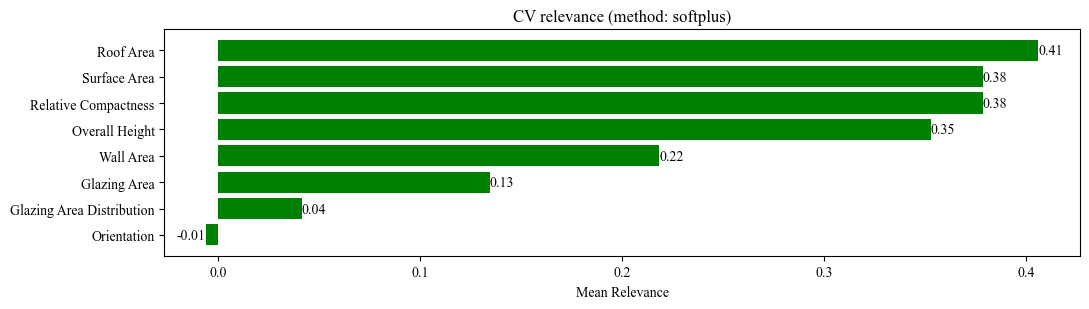

In [23]:
plot_cv_relevance(relevance_results, X.columns, method="softplus")

In [15]:
print_cv_relevance(relevance_results, X.columns, method="clip")

CV Relevance Results (method: clip):

Feature: Relative Compactness
  per fold: [0.55 0.57 0.55 0.6  0.54 0.56 0.52 0.56 0.56 0.58]
  mean relevance : 0.5592
  std relevance  : 0.0202

Feature: Surface Area
  per fold: [0.54 0.58 0.56 0.6  0.55 0.56 0.51 0.58 0.54 0.58]
  mean relevance : 0.5599
  std relevance  : 0.0252

Feature: Wall Area
  per fold: [-0.    0.15  0.19  0.29  0.3   0.02 -0.09  0.35  0.43  0.18]
  mean relevance : 0.1833
  std relevance  : 0.1575

Feature: Roof Area
  per fold: [0.59 0.61 0.6  0.63 0.68 0.6  0.55 0.66 0.63 0.58]
  mean relevance : 0.6134
  std relevance  : 0.0371

Feature: Overall Height
  per fold: [0.57 0.57 0.57 0.57 0.61 0.55 0.51 0.59 0.57 0.53]
  mean relevance : 0.5647
  std relevance  : 0.0257

Feature: Orientation
  per fold: [-0.   -0.01 -0.01 -0.02 -0.03 -0.02 -0.01 -0.01 -0.   -0.01]
  mean relevance : -0.0117
  std relevance  : 0.0075

Feature: Glazing Area
  per fold: [ 0.22  0.    0.02 -0.06  0.27  0.07  0.2  -0.02 -0.    0.1 ]
  mean r

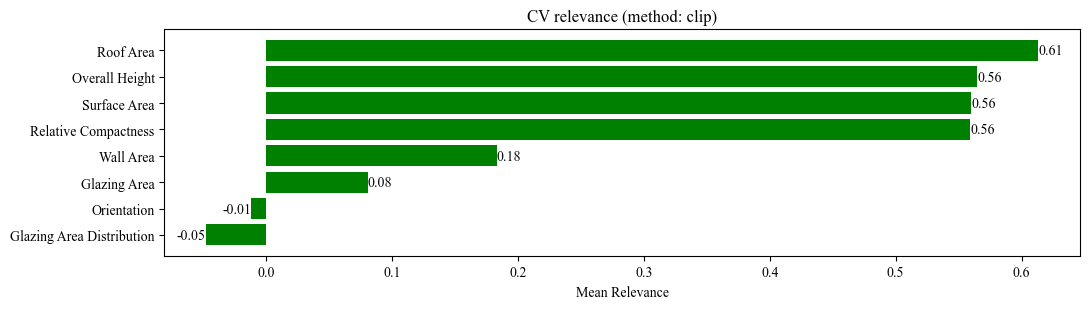

In [24]:
plot_cv_relevance(relevance_results, X.columns, method="clip")

### Novelty

In [17]:
from src.evaluation import novelty

columns_novelty = {}
for col in X.columns:
    softplus_novelty = novelty(
        X_train_norm, X_test_norm,
        y_train_norm, y_test_norm,
        col, N=4,
        lambda_val=1e-3,
        calibration_method="softplus"
    )
    clip_novelty = novelty(
        X_train_norm, X_test_norm,
        y_train_norm, y_test_norm,
        col, N=4,
        lambda_val=1e-3,
        calibration_method="clip"
    )

    columns_novelty[col] = {
        "softplus": softplus_novelty,
        "clip": clip_novelty
    }

In [18]:
def report_novelty(columns_novelty, method="softplus"):
    novelty_dict = {
        col: scores[method]
        for col, scores in columns_novelty.items()
    }
    sorted_items = sorted(novelty_dict.items(), key=lambda x: x[1], reverse=True)
    print(f"Feature Novelty Ranking (method: {method}):")
    for rank, (feature, novelty_score) in enumerate(sorted_items, start=1):
        print(f"{rank}. {feature}: {novelty_score:.4f}")

In [19]:
report_novelty(columns_novelty, method="softplus")

Feature Novelty Ranking (method: softplus):
1. Orientation: 0.0019
2. Glazing Area Distribution: 0.0013
3. Overall Height: -0.0003
4. Surface Area: -0.0044
5. Relative Compactness: -0.0097
6. Wall Area: -0.0379
7. Glazing Area: -0.0417
8. Roof Area: -0.0605


In [20]:
report_novelty(columns_novelty, method="clip")

Feature Novelty Ranking (method: clip):
1. Orientation: 0.0033
2. Glazing Area Distribution: 0.0022
3. Overall Height: -0.0003
4. Surface Area: -0.0050
5. Relative Compactness: -0.0121
6. Glazing Area: -0.0256
7. Wall Area: -0.0548
8. Roof Area: -0.0775


### Novelty (10-fold Cross Validation)

In [21]:
from src.cv import cv_novelty, print_cv_novelty, plot_cv_novelty
novelty_results = cv_novelty(X, y)

Fold 1
  Evaluating novelty for feature: Relative Compactness
  Evaluating novelty for feature: Surface Area
  Evaluating novelty for feature: Wall Area
  Evaluating novelty for feature: Roof Area
  Evaluating novelty for feature: Overall Height
  Evaluating novelty for feature: Orientation
  Evaluating novelty for feature: Glazing Area
  Evaluating novelty for feature: Glazing Area Distribution
Fold 2
  Evaluating novelty for feature: Relative Compactness
  Evaluating novelty for feature: Surface Area
  Evaluating novelty for feature: Wall Area
  Evaluating novelty for feature: Roof Area
  Evaluating novelty for feature: Overall Height
  Evaluating novelty for feature: Orientation
  Evaluating novelty for feature: Glazing Area
  Evaluating novelty for feature: Glazing Area Distribution
Fold 3
  Evaluating novelty for feature: Relative Compactness
  Evaluating novelty for feature: Surface Area
  Evaluating novelty for feature: Wall Area
  Evaluating novelty for feature: Roof Area


/home/julia/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.966e-02, tolerance: 6.901e-02
  model = cd_fast.enet_coordinate_descent(
/home/julia/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.343e-02, tolerance: 6.907e-02
  model = cd_fast.enet_coordinate_descent(
/home/julia/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

  Evaluating novelty for feature: Overall Height
  Evaluating novelty for feature: Orientation
  Evaluating novelty for feature: Glazing Area
  Evaluating novelty for feature: Glazing Area Distribution
Fold 4
  Evaluating novelty for feature: Relative Compactness
  Evaluating novelty for feature: Surface Area
  Evaluating novelty for feature: Wall Area
  Evaluating novelty for feature: Roof Area
  Evaluating novelty for feature: Overall Height
  Evaluating novelty for feature: Orientation


/home/julia/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.078e-01, tolerance: 6.900e-02
  model = cd_fast.enet_coordinate_descent(
/home/julia/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.078e-01, tolerance: 6.900e-02
  model = cd_fast.enet_coordinate_descent(


  Evaluating novelty for feature: Glazing Area
  Evaluating novelty for feature: Glazing Area Distribution
Fold 5
  Evaluating novelty for feature: Relative Compactness
  Evaluating novelty for feature: Surface Area
  Evaluating novelty for feature: Wall Area
  Evaluating novelty for feature: Roof Area
  Evaluating novelty for feature: Overall Height
  Evaluating novelty for feature: Orientation
  Evaluating novelty for feature: Glazing Area
  Evaluating novelty for feature: Glazing Area Distribution
Fold 6
  Evaluating novelty for feature: Relative Compactness
  Evaluating novelty for feature: Surface Area
  Evaluating novelty for feature: Wall Area
  Evaluating novelty for feature: Roof Area
  Evaluating novelty for feature: Overall Height
  Evaluating novelty for feature: Orientation
  Evaluating novelty for feature: Glazing Area
  Evaluating novelty for feature: Glazing Area Distribution
Fold 7
  Evaluating novelty for feature: Relative Compactness
  Evaluating novelty for feature:

In [26]:
print_cv_novelty(novelty_results, X.columns, method="softplus")

CV Novelty Results (method: softplus):

Feature: Relative Compactness
  per fold: [-0.01 -0.01 -0.   -0.01 -0.01 -0.   -0.01 -0.   -0.01 -0.  ]
  mean novelty : -0.0047
  std novelty  : 0.0018

Feature: Surface Area
  per fold: [-0. -0. -0.  0. -0. -0. -0. -0. -0. -0.]
  mean novelty : -0.0012
  std novelty  : 0.0013

Feature: Wall Area
  per fold: [-0.07 -0.03 -0.04 -0.03 -0.02 -0.03 -0.03 -0.04 -0.04 -0.05]
  mean novelty : -0.0377
  std novelty  : 0.0139

Feature: Roof Area
  per fold: [-0.07 -0.05 -0.04 -0.06 -0.03 -0.06 -0.06 -0.01 -0.04 -0.04]
  mean novelty : -0.0457
  std novelty  : 0.0155

Feature: Overall Height
  per fold: [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
  mean novelty : -0.0006
  std novelty  : 0.0005

Feature: Orientation
  per fold: [-0.  0. -0.  0.  0.  0.  0.  0. -0.  0.]
  mean novelty : 0.0010
  std novelty  : 0.0010

Feature: Glazing Area
  per fold: [-0.05 -0.07 -0.06 -0.05 -0.06 -0.06 -0.05 -0.05 -0.05 -0.05]
  mean novelty : -0.0544
  std novelty  : 0.00

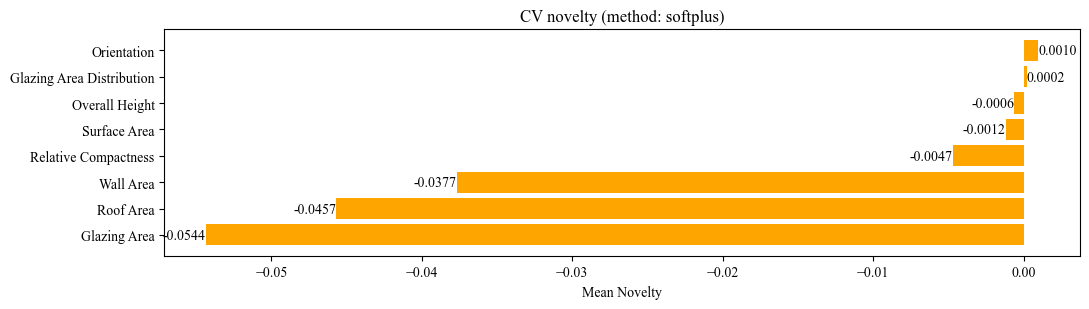

In [27]:
plot_cv_novelty(novelty_results, X.columns, method="softplus")

In [28]:
print_cv_novelty(novelty_results, X.columns, method="clip")

CV Novelty Results (method: clip):

Feature: Relative Compactness
  per fold: [-0.01 -0.01 -0.   -0.01 -0.01 -0.   -0.01 -0.   -0.01  0.  ]
  mean novelty : -0.0054
  std novelty  : 0.0032

Feature: Surface Area
  per fold: [-0. -0. -0.  0. -0. -0. -0. -0. -0. -0.]
  mean novelty : -0.0013
  std novelty  : 0.0016

Feature: Wall Area
  per fold: [-0.09 -0.04 -0.05 -0.04  0.11 -0.04 -0.04 -0.05 -0.06 -0.05]
  mean novelty : -0.0346
  std novelty  : 0.0515

Feature: Roof Area
  per fold: [-0.08 -0.07 -0.06 -0.08  0.09 -0.08 -0.07 -0.01 -0.05 -0.03]
  mean novelty : -0.0439
  std novelty  : 0.0507

Feature: Overall Height
  per fold: [-0.  0. -0. -0. -0. -0. -0. -0. -0. -0.]
  mean novelty : -0.0007
  std novelty  : 0.0006

Feature: Orientation
  per fold: [-0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  mean novelty : 0.0013
  std novelty  : 0.0011

Feature: Glazing Area
  per fold: [-0.03 -0.06 -0.05 -0.02 -0.04 -0.05 -0.04 -0.02 -0.03 -0.03]
  mean novelty : -0.0367
  std novelty  : 0.0115



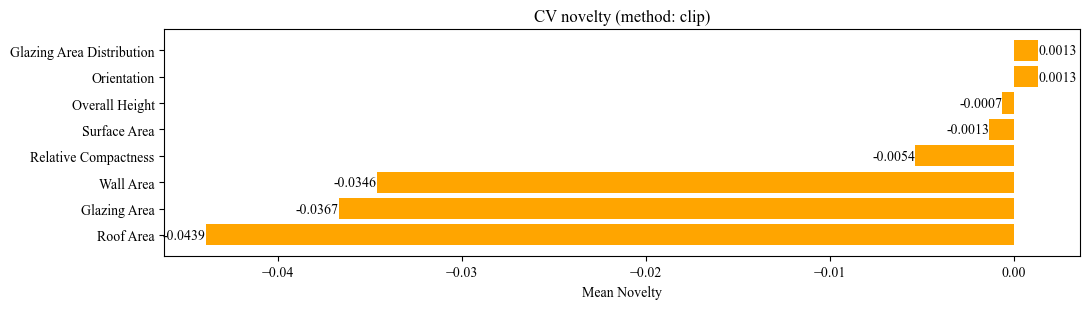

In [29]:
plot_cv_novelty(novelty_results, X.columns, method="clip")